# Moment Tensor Wavefield Inversion - Multi Component
## The inverse crime edition

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.optimization.sparsity import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.modelling.trueamp_kirchhoff import Kirchhoff as TAKirchhoff

from pyfrac.mtsolvers.mtwi import *
from pyfrac.mtsolvers.homo_mti import collect_source_angles, multicomp_Greens_Pwave
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict

from pyfrac.visualisation.eventimages import locimage3d

# 3D Model - Homo

In [3]:
# Velocity Model
nx, ny, nz = 47, 51, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 143)
[[  4.  180.  162.4 144.8 127.2 109.6  92.   74.4  56.8  39.2  21.6   4.
  180.  162.4 144.8]
 [  4.    4.   20.   36.   52.   68.   84.  100.  116.  132.  148.  164.
  164.  180.  196. ]
 [  4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.
    4.    4.    4. ]]
[  4.  20.  36.  52.  68.  84. 100. 116. 132. 148. 164. 180. 196.] 200 [  4.   21.6  39.2  56.8  74.4  92.  109.6 127.2 144.8 162.4 180. ] 184


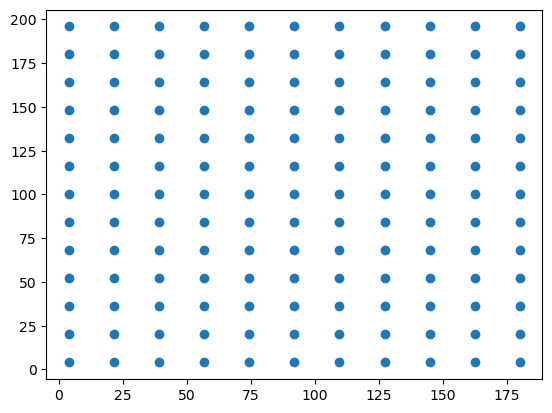

In [4]:
# RECEIVERS
grid_rx_locs = np.linspace(dx, (dx*nx)-2*dx, 11)
grid_ry_locs = np.linspace(dy, (dy*ny)-2*dy, 13)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])
print(grid_ry_locs, y.max(), grid_rx_locs, x.max())

## Get all necessary components

In [5]:
%%time

# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs,  
                                   vel=vel, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

CPU times: user 15.5 s, sys: 227 ms, total: 15.7 s
Wall time: 15.7 s


In [6]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [7]:
# Source Parameters
omega_p = 30  # Assume central frequency of 25Hz
sloc_ind = [nx//2, ny//2, nz//2]  # As indices of velocity model

### AREA OF INTEREST

In [8]:
# Make cube area of interest as can't consider the full subsurface body
hwin_nx_aoi, hwin_ny_aoi, hwin_nz_aoi = 15, 13, 11  # half windows to place source in center of region of interest
xsi, xfi = sloc_ind[0]-hwin_nx_aoi, sloc_ind[0]+hwin_nx_aoi+1   # start/end index of x-region of interest
ysi, yfi = sloc_ind[1]-hwin_ny_aoi, sloc_ind[1]+hwin_ny_aoi+1   # start/end index of y-region of interest
zsi, zfi = sloc_ind[2]-hwin_nz_aoi, sloc_ind[2]+hwin_nz_aoi+1   # start/end index of z-region of interest

In [9]:
# Parameters only for the area of interest
gamma_sourceangles_aoi = gamma_sourceangles[:, :, xsi:xfi, ysi:yfi, zsi:zfi]
dist_table_aoi = dist_table[:, xsi:xfi, ysi:yfi, zsi:zfi]
tt_table_aoi = TTT_full[:, xsi:xfi, ysi:yfi, zsi:zfi]

nr, nx_aoi, ny_aoi, nz_aoi = tt_table_aoi.shape
print(nr, nx_aoi, ny_aoi, nz_aoi)

143 31 27 23


In [10]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for area of interest

In [11]:
Gx, Gy, Gz = multicomp_Greens_Pwave(nxyz=[nx_aoi, ny_aoi, nz_aoi],
                                    nr=nr,
                                    gamma_sourceangles=gamma_sourceangles_aoi,
                                    dist_table=dist_table_aoi,
                                    vel=vel,
                                    MT_comp_dict=MT_comp_dict,
                                    omega_p=1,
                                    )

In [12]:
Gx.shape

(6, 143, 31, 27, 23)

# Moment Tensor Kirchhoff Imaging

### MAKE OPERATOR

In [13]:
# Time and Wavelet Information
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=omega_p)

In [14]:
Mstack_Op = multicomp_pwave_mtioperator(x=x[xsi:xfi],
                                        y=y[ysi:yfi],
                                        z=z[zsi:zfi],
                                        recs=recs,
                                        t=t,
                                        wav=wav,
                                        wavc=wavc,
                                        tt_table=tt_table_aoi,
                                        Gx=Gx,
                                        Gy=Gy,
                                        Gz=Gz,
                                        Ms_scaling = 1e6,
                                        engine='numba'
                                        )

Dot test passed, v^H(Opu)=-0.09801817842801319 - u^H(Op^Hv)=-0.09801817842801344


## INVERSE CRIME - Make data with forward operation

In [15]:
# Modelled MT
MT_aoi = np.zeros([6, nx_aoi, ny_aoi, nz_aoi])  # MT components as images
MT_selected =-1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 
MT_aoi[:, nx_aoi//2, ny_aoi//2, nz_aoi//2] = MT_selected

# Generated Data
data = Mstack_Op @ MT_aoi.ravel()
data = data.reshape(3, nr, nt)

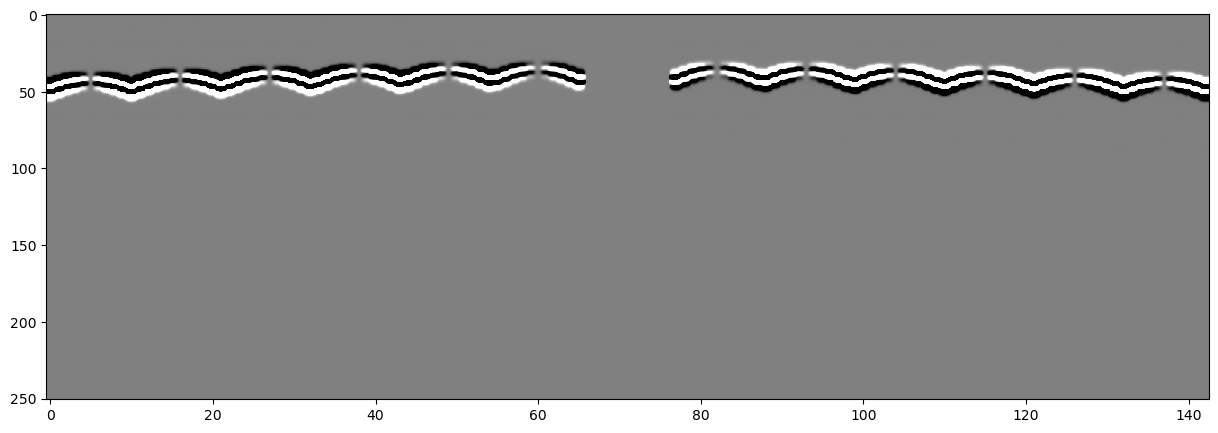

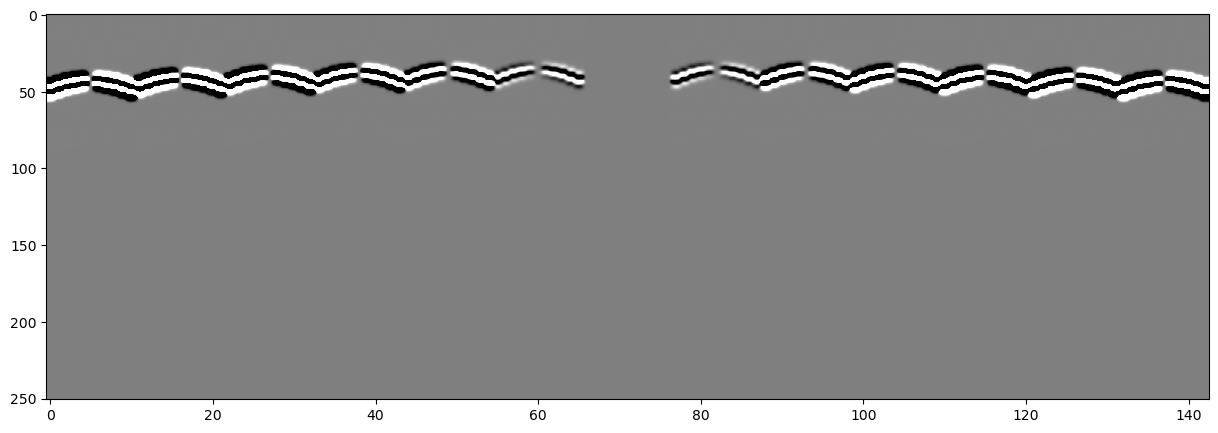

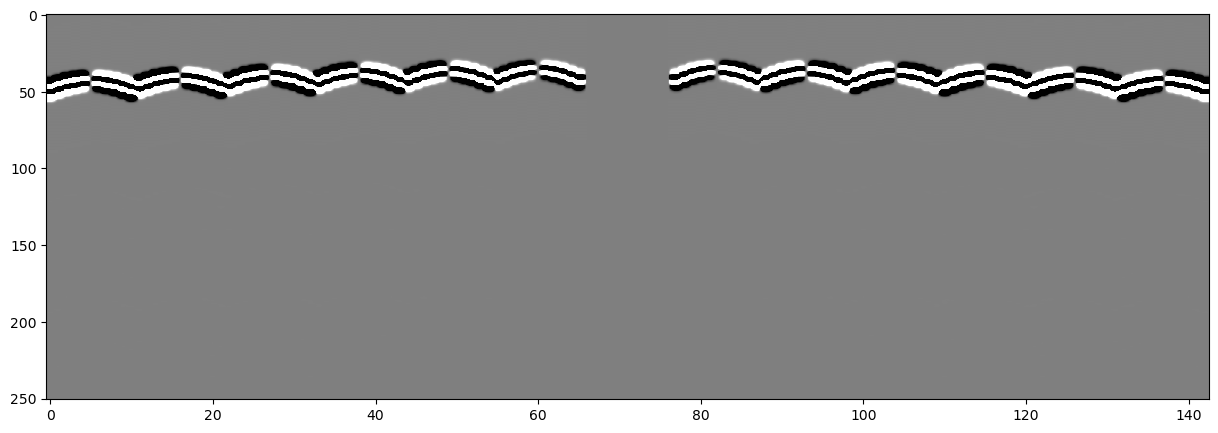

In [16]:
plt.figure(figsize=(15, 5))
plt.imshow(data[0].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[1].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[2].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');

In [17]:
nxyz=[nx_aoi, ny_aoi, nz_aoi]

# ADJOINT
mt_adj = adjoint_mtmodelling(data, Mstack_Op, nxyz)

# LSQR
mt_inv = lsqr_mtsolver(data, Mstack_Op, nxyz)

# FISTA
mt_fista = fista_mtsolver(data, Mstack_Op, nxyz, fista_niter=100, fista_damping=1e-13, verbose=True)


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 107679 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.738e-04  1.738e-04    1.0e+00  9.8e+01
     1 -2.18482e-06   8.795e-05  8.795e-05    5.1e-01  5.5e-01   2.0e-02  1.0e+00
     2 -5.02460e-06   6.194e-05  6.194e-05    3.6e-01  3.3e-01   2.6e-02  2.2e+00
     3 -1.51960e-06   4.837e-05  4.837e-05    2.8e-01  2.2e-01   3.0e-02  3.7e+00
     4  4.09412e-06   4.052e-05  4.052e-05    2.3e-01  1.6e-01   3.4e-02  5.3e+00
     5  5.05272e-06   3.620e-05  3.620e-05    2.1e-01  1.3e-01   3.7e-02  7.0e+00
     6  5.73908e-06   3.281e-05  3.281e-05    1.9e-01  1.1e-01   3.9e-02  9.1e+00
     7  3.50211e-06   3.027e-05  3.027e-05    1.7e-01  9.6e-02   4.2e-02  1.1e+01
     8 -1.10058e-06   2.835e-0

In [18]:
mt_fista.max()

0.0011755252039011145

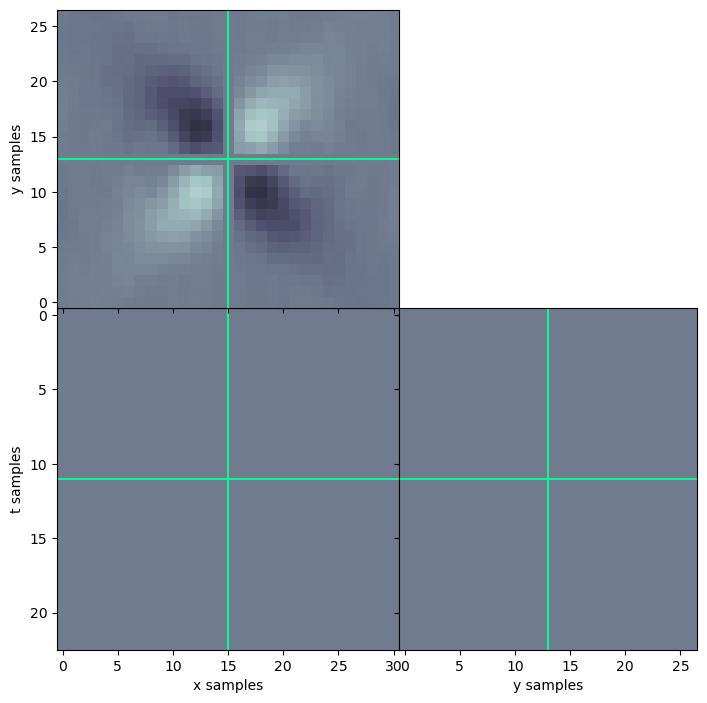

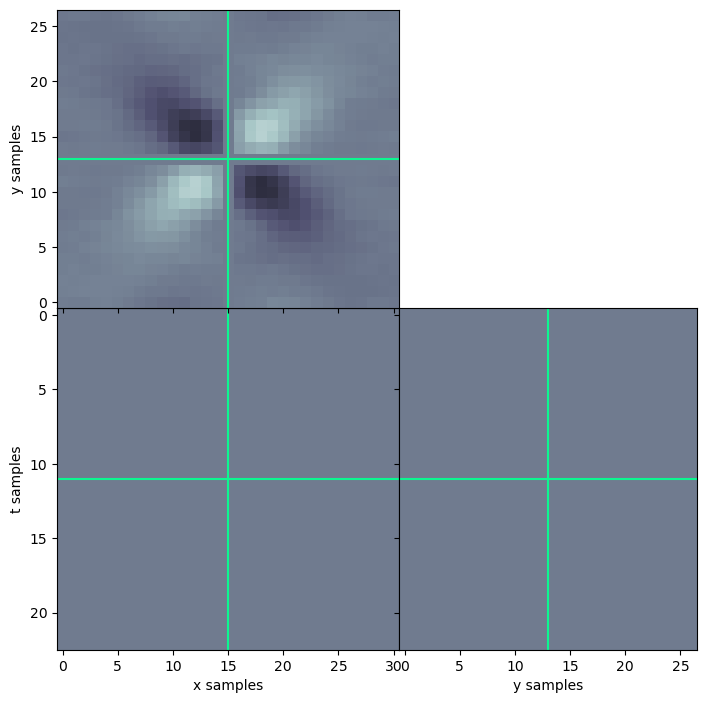

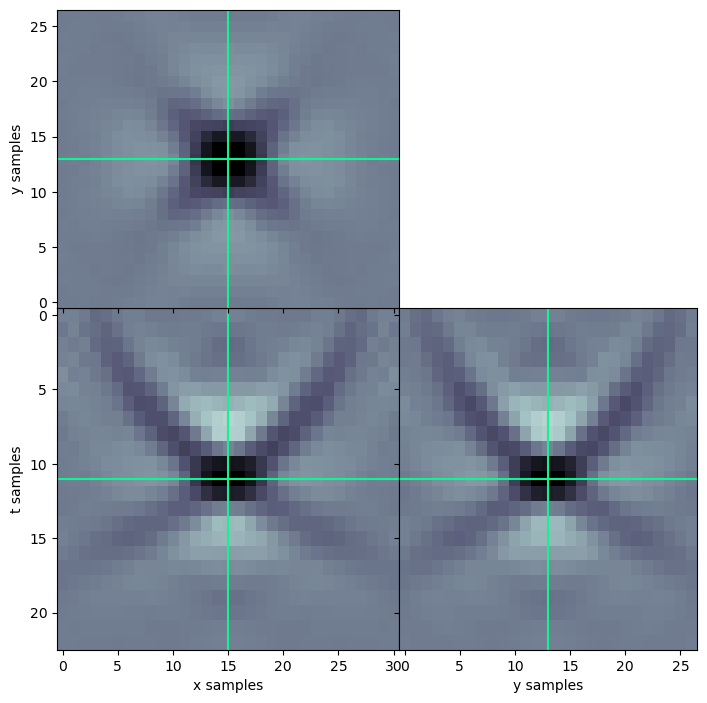

In [19]:
locimage3d(mt_fista[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(mt_fista[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(mt_fista[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);